In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
import pathlib
import sys
import pandas as pd
sys.path.append('../dataset/')
sys.path.append('../models/')
from PIL import Image
from unet import unet_2D, UNet
import torch
from catalyst import dl, metrics, utils;
import albumentations as A
from dataset import AsbestosDataSet
from torch.utils.data import DataLoader
from torch import nn

/home/kirill/anaconda3/envs/conda_3.8/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
image_dir = '/home/kirill/Учеба/asbestos/task_asbestos_stone_161220-2021_01_13_12_39_03-segmentation mask 1.1 (1)/JPEGImages/asbestos/stones/161220'
mask_dir  = '/home/kirill/Учеба/asbestos/task_asbestos_stone_161220-2021_01_13_12_39_03-segmentation mask 1.1 (1)/SegmentationAsbest'
t_h = 128
transform = A.Compose([A.RandomCrop(width=512*3, height=512*3),
                       A.Resize(t_h,t_h), A.RandomRotate90()])

dataset = AsbestosDataSet(image_dir, mask_dir, transform)
data_loader = DataLoader(dataset, num_workers=1, batch_size = 1)
loaders = {"train":data_loader}


In [3]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
    def forward(self, inputs, targets, smooth=1e-5):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        return 1 - dice
    
class DiceLoss(nn.Module):
    """
        prediction (P): Предсказываемая разметка
        target     (T): Целевая разметка
        Функция Даеса.
        Находит отношение пересечения A и T к объединению A и T.
        Результат вычитается из единицы с целью использования при оптимизации.
    """
    def __init__(self):
        super().__init__()
    def forward(self, prediction, target):
        assert prediction.size() == target.size()
        prediction = prediction.view(-1)
        target = target.view(-1)
        intersection = (prediction*target).sum()
        # union=(prediction*prediction).sum() + (target*target).sum() + 1e-6
        # dcs = (2. * intersection)/union
        union=((1-prediction)*target).sum()+(prediction*(1-target)).sum()+intersection + 1e-6
        return 1-intersection/union
    
DiceLoss().forward(torch.tensor([0,1,1,1]),torch.tensor([0,1,0,1]))

tensor(0.3333)

In [4]:
class CustomRunner(dl.Runner):
    def predict_batch(self, batch):
        return self.model(batch['image'].to(self.device))
    def on_loader_start(self, runner):
        super().on_loader_start(runner)
        self.meters = { key: metrics.AdditiveValueMetric(compute_on_call=True)
                        for key in ["loss", "iou"]}
        
    def handle_batch(self, batch):
        image, mask, name = batch.values()
        #----------
        image = image.unsqueeze(0)/255
        mask  = mask.unsqueeze(0)
        #------------
        predict = self.model(image)#batch size
        loss = self.criterion(image, predict)
        #Создаем обьект
        iou_metric = metrics.IOUMetric()
        iou = iou_metric.update_key_value(predict, mask)['iou']
        self.batch_metrics.update(
            {"loss": loss, "iou": iou}
        )
        for key in ["loss", "iou"]:
            self.meters[key].update( self.batch_metrics[key].item(), self.batch_size)
        iou_metric.reset()
        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
    def on_loader_end(self, runner):
        for key in ["loss", "iou"]:
            self.loader_metrics[key] = self.meters[key].compute()[0]
        super().on_loader_end(runner)   

In [5]:
t1 = torch.tensor([[1,0,1]])
t2 = torch.tensor([[1,0,0.9]])

iou_metric = metrics.IOUMetric()
iou = iou_metric.update_key_value(t1,t2)['iou']
iou

tensor(0.9667)

In [ ]:
unet = unet_2D(feature_scale=1, n_classes = 1, 
               in_channels=1, is_deconv = True,
               is_debug=False, )
unet = UNet(n_channels=1, n_classes = 1 )

In [16]:

criterion = DiceLoss()
optimizer = torch.optim.Adam(unet.parameters())
runner = CustomRunner()
runner.train(
    model=unet,
    criterion = criterion,
    optimizer=optimizer,
    loaders=loaders,
    num_epochs=10,
    logdir = 'unet_log',
    verbose=True)


train (1/10) iou: -0.345751669911439 | loss: -2.0522974112577606
* Epoch (1/10) 



train (2/10) iou: -0.5415208670392371 | loss: 1.9447602075442936
* Epoch (2/10) 



train (3/10) iou: -0.5867751657047814 | loss: 1.8554794809274506
* Epoch (3/10) 



train (4/10) iou: -0.6276492764029589 | loss: 1.564592298708464
* Epoch (4/10) 



train (5/10) iou: -0.6636382341384887 | loss: 1.4120593144182572
* Epoch (5/10) 



train (6/10) iou: -0.6874818728681196 | loss: 1.361862286141044
* Epoch (6/10) 



train (7/10) iou: -0.7153089668667107 | loss: 1.2296940401980752
* Epoch (7/10) 



train (8/10) iou: -0.6621256915100833 | loss: 1.0685853058831736
* Epoch (8/10) 



train (9/10) iou: -0.028341045243698244 | loss: 7.756797989209493
* Epoch (9/10) 



train (10/10) iou: 0.14789505512045134 | loss: 0.9523013202767624
* Epoch (10/10) 
Top best models:
unet_log/checkpoints/train.10.pth	10.0000


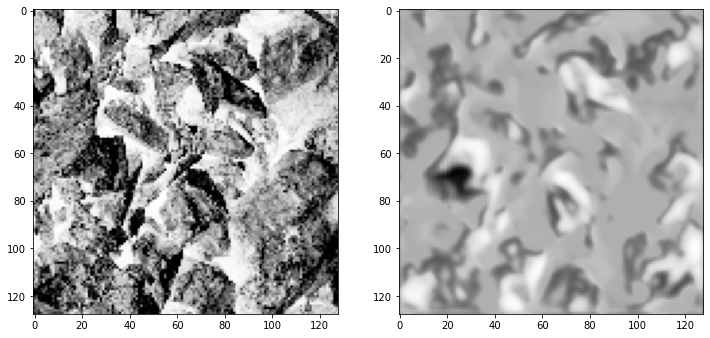

In [17]:
image = next(data_loader.__iter__())['image']
image = image.unsqueeze(0)/255
out = unet(image)
# out = unet_2D.apply_argmax_softmax(out)
pred_mask  = out[0][0].detach().numpy() 
# pred_mask = pred_mask[pred_mask>0.5]
fig, ax = plt.subplots(1,2, figsize = (12,12))
ax[0].imshow(image[0][0].detach().numpy(), cmap='Greys')
# pred_mask[np.array(pred_mask<0.01,dtype =int)] = 1
ax[1].imshow(pred_mask, cmap='Greys')
fig

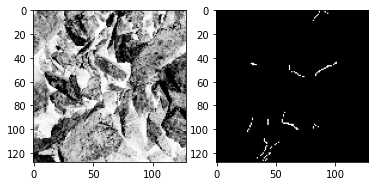

In [8]:
ex = next(data_loader.__iter__())

image = ex['image']
mask = ex['mask']
# image[].detach().numpy()
fig = plt.figure(figsize=(10,10))
t = np.random.rand(64,64)
fig, ax = plt.subplots(1,2)

ax[0].imshow(image[0].detach().numpy(), cmap='Greys')
ax[1].imshow(mask[0].detach().numpy(), cmap='Greys')
fig